### Import Library

In [51]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report


### Load Dataset

In [ ]:
# Dataset harus berada di drive anda dan colab diberi izin untuk mengakses drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Path
DATASET_ROOT = "/content/drive/MyDrive/dataset"


TRAIN_DIR = os.path.join(DATASET_ROOT, "Training")
VAL_DIR   = os.path.join(DATASET_ROOT, "Validation")
TEST_DIR  = os.path.join(DATASET_ROOT, "Testing")

# Parameters
IMG_SIZE = (224, 224)     # MobileNetV2 input size
BATCH_SIZE = 32
EPOCHS = 10               # safe default

train_ds = keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

test_ds = keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    shuffle=False
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 716 files belonging to 2 classes.
Found 180 files belonging to 2 classes.
Found 224 files belonging to 2 classes.
Classes: ['NotSmoking', 'Smoking']


### Optmisasi Performa

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)


### Preprocessing (Data augmentation & Rescaling Layer)

In [ ]:
data_augmentation = tf.keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.15),
    keras.layers.RandomTranslation(0.1, 0.1),
    keras.layers.RandomContrast(0.15),
    keras.layers.RandomBrightness(0.1),
])


In [ ]:
preprocess_layer = keras.layers.Rescaling(
    scale=1./127.5,
    offset=-1
)


### Load MobileNetV2 & Build Model

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False


In [ ]:
inputs = keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)
x = preprocess_layer(x)
x = base_model(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

### Compile Model

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Train Model

In [41]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15
)


Epoch 1/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.5555 - loss: 0.7835 - val_accuracy: 0.8778 - val_loss: 0.4197
Epoch 2/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.7034 - loss: 0.5585 - val_accuracy: 0.8889 - val_loss: 0.3466
Epoch 3/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.7382 - loss: 0.5243 - val_accuracy: 0.9000 - val_loss: 0.2938
Epoch 4/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7601 - loss: 0.4814 - val_accuracy: 0.9056 - val_loss: 0.2782
Epoch 5/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7780 - loss: 0.4746 - val_accuracy: 0.9000 - val_loss: 0.2663
Epoch 6/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7843 - loss: 0.4291 - val_accuracy: 0.9000 - val_loss: 0.2572
Epoch 7/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7990 - loss: 0.4192 - val_accuracy: 0.9167 - val_loss: 0.2288
Epoch 8/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.8191 - loss: 0.4098 - val_accuracy: 0.9222 - val_loss:

### Plotting

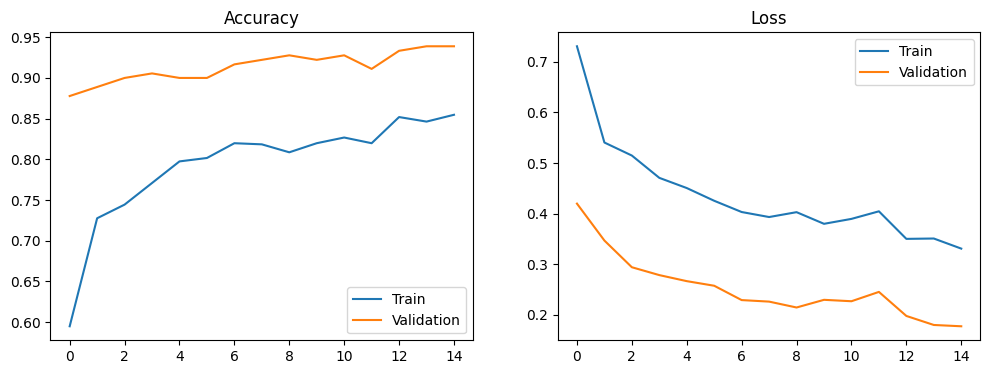

In [42]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.title("Loss")
plt.legend()

plt.show()


### Evaluate Test Dataset, Confusion Matrix, & Classification Report

In [43]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    preds = (preds > 0.5).astype(int).flatten()
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=class_names))


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8312 - loss: 0.3497
Test Accuracy: 0.8884
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[ 91  21]
 [  4 108]]
              precision    recall  f1-score   support

  NotSmoking       0.96      0.81      0.88       112
     Smoking       0.84      0.96      0.90       112

    accuracy                           0.89       224
   macro avg       0.90      0.89      0.89       224
weighted avg       0.90      0.89      0.89       224



In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

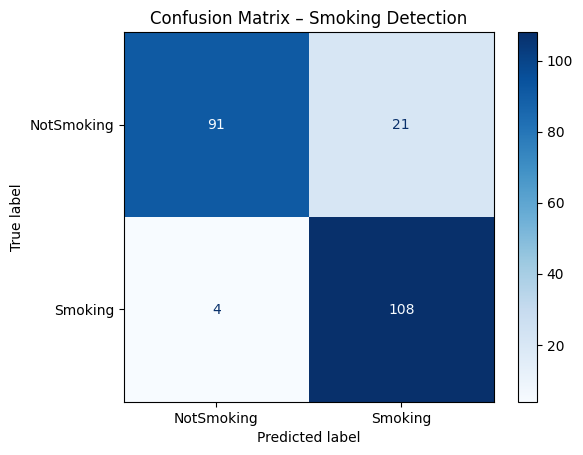

In [49]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["NotSmoking", "Smoking"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – Smoking Detection")
plt.show()


### Save Model

In [47]:
model.save("smoker_detection_mobilenetv2_final2.keras")
